In [18]:
# Cell 0: Install required packages
! pip install numpy pandas matplotlib scikit-learn tensorflow requests


In [19]:
# Cell 1: Import all required dependencies
import os
import zipfile
import requests
from io import BytesIO
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks


In [20]:
# Cell 2: Check if TensorFlow can use GPU (CUDA)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is available and configured for training.")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No GPU detected, training will run on CPU.")


❌ No GPU detected, training will run on CPU.


In [21]:
# Cell 3: Automatically find and load HousesInfo.txt
import os, glob
import pandas as pd

# Set a broad folder where your dataset is located (can be root folder)
dataset_root = "."  # current directory, change if needed

# Search recursively for HousesInfo.txt
matches = glob.glob(os.path.join(dataset_root, "**", "HousesInfo.txt"), recursive=True)

if matches:
    meta_file = matches[0]  # take the first match
    col_names = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
    df = pd.read_csv(meta_file, sep=" ", header=None, names=col_names)
    print("✅ Metadata loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Loaded from: {meta_file}")
    display(df.head())
else:
    raise FileNotFoundError(f"❌ Could not find HousesInfo.txt anywhere inside {dataset_root}")


✅ Metadata loaded successfully!
Shape: (535, 5)
Loaded from: .\houses_dataset\Houses-dataset-master\Houses Dataset\HousesInfo.txt


,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [22]:
# Cell 4: Prepare tabular features and split dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure df exists
if 'df' not in globals():
    raise ValueError("df is not defined. Run metadata loading cell first.")

# Select tabular features and target
X_tab = df[["bedrooms", "bathrooms", "area", "zipcode"]].values
y_tab = df["price"].values

# Split into train/test sets
X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_tab, y_tab, test_size=0.2, random_state=42
)

# Standardize tabular features
scaler = StandardScaler()
X_tab_train = scaler.fit_transform(X_tab_train)
X_tab_test = scaler.transform(X_tab_test)

# Print summary
print("✅ Tabular data prepared")
print(f"X_tab_train shape: {X_tab_train.shape}")
print(f"X_tab_test shape: {X_tab_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


✅ Tabular data prepared
X_tab_train shape: (428, 4)
X_tab_test shape: (107, 4)
y_train shape: (428,)
y_test shape: (107,)


In [23]:
# Cell 4: Prepare tabular features and split dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure df exists
if 'df' not in globals():
    raise ValueError("df is not defined. Run Cell 3 first.")

# Select tabular features and target
X_tab = df[["bedrooms", "bathrooms", "area", "zipcode"]].values
y_tab = df["price"].values

# Split into train/test sets
X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_tab, y_tab, test_size=0.2, random_state=42
)

# Standardize tabular features
scaler = StandardScaler()
X_tab_train = scaler.fit_transform(X_tab_train)
X_tab_test = scaler.transform(X_tab_test)

print("✅ Tabular data prepared")
print(f"X_tab_train shape: {X_tab_train.shape}")
print(f"X_tab_test shape: {X_tab_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


✅ Tabular data prepared
X_tab_train shape: (428, 4)
X_tab_test shape: (107, 4)
y_train shape: (428,)
y_test shape: (107,)


In [24]:
# Cell 5: No image data available, using tabular data only
X_img_train = np.zeros((X_tab_train.shape[0], 1, 1, 1), dtype=np.float32)
X_img_test  = np.zeros((X_tab_test.shape[0], 1, 1, 1), dtype=np.float32)
print("✅ Placeholder image data created for tabular-only model")


✅ Placeholder image data created for tabular-only model


In [25]:
# Cell 6: Scale target (price) for stable training
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))

print("✅ Target values scaled")


✅ Target values scaled


In [16]:
# Cell 7: Check GPU and enable memory growth
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No GPU detected, training will run on CPU.")


❌ No GPU detected, training will run on CPU.


In [26]:
# Cell 8: Early stopping and model checkpoint
from tensorflow.keras import callbacks

# Stop training if val_loss doesn't improve for 10 epochs
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Save the best model based on validation loss
checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",   # File to save best weights
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

print("✅ Callbacks defined")


✅ Callbacks defined


In [27]:
# Cell 9: tf.data pipeline for memory-efficient training
import tensorflow as tf

BATCH_SIZE = 16

# Ensure tabular data is dense
if not isinstance(X_tab_train, np.ndarray):
    X_tab_train = X_tab_train.toarray()
if not isinstance(X_tab_test, np.ndarray):
    X_tab_test = X_tab_test.toarray()

# Build tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((X_img_train, X_tab_train), y_train_scaled))
test_dataset  = tf.data.Dataset.from_tensor_slices(((X_img_test, X_tab_test), y_test_scaled))

# Shuffle, batch, prefetch
train_dataset = train_dataset.shuffle(buffer_size=len(X_img_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ tf.data datasets ready")


✅ tf.data datasets ready


In [29]:
# Cell 10a: Define multimodal model (tabular + dummy image)
from tensorflow.keras import layers, models, Input

# Image input (dummy 1x1x1 input)
image_input = Input(shape=(1,1,1), name="image_input")
x_img = layers.Flatten()(image_input)
x_img = layers.Dense(16, activation="relu")(x_img)

# Tabular input
tab_input = Input(shape=(X_tab_train.shape[1],), name="tab_input")
x_tab = layers.Dense(32, activation="relu")(tab_input)
x_tab = layers.Dense(16, activation="relu")(x_tab)

# Concatenate
x = layers.concatenate([x_img, x_tab])
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)
output = layers.Dense(1, activation="linear")(x)

# Model
model = models.Model(inputs=[image_input, tab_input], outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 1, 1, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab_input           │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        160 │ tab_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         32 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      1,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         17 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,321 (9.07 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]
)


In [32]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.0231 - mae: 0.1195
Epoch 1: val_loss improved from None to 0.02204, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0238 - mae: 0.1049 - val_loss: 0.0220 - val_mae: 0.1049
Epoch 2/20
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - mae: 0.0974
Epoch 2: val_loss improved from 0.02204 to 0.01769, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - mae: 0.0872 - val_loss: 0.0177 - val_mae: 0.0905
Epoch 3/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0175 - mae: 0.0912
Epoch 3: val_loss improved from 0.01769 to 0.01470, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - mae: 0.0764 - val_loss: 0.0147 - val_mae: 0.0804
Epoch 4/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - mae: 0.0914
Epoch 4: val_loss improved from 0.01470 to 0.01244, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - mae: 0.0701 - val_loss: 0.0124 - val_mae: 0.0739
Epoch 5/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - mae: 0.0748
Epoch 5: val_loss improved from 0.01244 to 0.01030, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - mae: 0.0657 - val_loss: 0.0103 - val_mae: 0.0682
Epoch 6/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0252 - mae: 0.0940
Epoch 6: val_loss improved from 0.01030 to 0.00927, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mae: 0.0624 - val_loss: 0.0093 - val_mae: 0.0646
Epoch 7/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - mae: 0.0790
Epoch 7: val_loss improved from 0.00927 to 0.00768, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - mae: 0.0598 - val_loss: 0.0077 - val_mae: 0.0603
Epoch 8/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - mae: 0.0744
Epoch 8: val_loss improved from 0.00768 to 0.00715, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - mae: 0.0576 - val_loss: 0.0071 - val_mae: 0.0583
Epoch 9/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104 - mae: 0.0768
Epoch 9: val_loss improved from 0.00715 to 0.00632, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mae: 0.0556 - val_loss: 0.0063 - val_mae: 0.0555
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 - mae: 0.0533
Epoch 10: val_loss improved from 0.00632 to 0.00575, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - mae: 0.0538 - val_loss: 0.0057 - val_mae: 0.0535
Epoch 11/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0320 - mae: 0.0943
Epoch 11: val_loss improved from 0.00575 to 0.00530, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - mae: 0.0533 - val_loss: 0.0053 - val_mae: 0.0519
Epoch 12/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mae: 0.0369
Epoch 12: val_loss improved from 0.00530 to 0.00482, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - mae: 0.0516 - val_loss: 0.0048 - val_mae: 0.0502
Epoch 13/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0427
Epoch 13: val_loss improved from 0.00482 to 0.00440, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - mae: 0.0504 - val_loss: 0.0044 - val_mae: 0.0487
Epoch 14/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0427
Epoch 14: val_loss improved from 0.00440 to 0.00410, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0493 - val_loss: 0.0041 - val_mae: 0.0478
Epoch 15/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - mae: 0.0340
Epoch 15: val_loss improved from 0.00410 to 0.00380, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - mae: 0.0485 - val_loss: 0.0038 - val_mae: 0.0466
Epoch 16/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - mae: 0.0257
Epoch 16: val_loss improved from 0.00380 to 0.00354, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0453
Epoch 17/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mae: 0.0331
Epoch 17: val_loss improved from 0.00354 to 0.00346, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - mae: 0.0467 - val_loss: 0.0035 - val_mae: 0.0452
Epoch 18/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - mae: 0.0414
Epoch 18: val_loss improved from 0.00346 to 0.00344, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - mae: 0.0466 - val_loss: 0.0034 - val_mae: 0.0453
Epoch 19/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - mae: 0.0375
Epoch 19: val_loss improved from 0.00344 to 0.00317, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mae: 0.0457 - val_loss: 0.0032 - val_mae: 0.0436
Epoch 20/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - mae: 0.0371
Epoch 20: val_loss improved from 0.00317 to 0.00307, saving model to best_model.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - mae: 0.0450 - val_loss: 0.0031 - val_mae: 0.0431


In [33]:
# Cell 12: Make predictions and inverse-transform
y_pred_scaled = model.predict(test_dataset)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

print("✅ Predictions converted to original scale")
print(f"Example predictions: {y_pred[:5].flatten()}")
print(f"Example true values: {y_test[:5]}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
✅ Predictions converted to original scale
Example predictions: [461783.8  567708.44 676304.75 925973.6  585515.7 ]
Example true values: [ 485000 1199000  170000  538000  689000]


In [34]:
# Cell 13: Compute metrics on original scale
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model evaluation complete")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


✅ Model evaluation complete
MAE: 251294.67
RMSE: 323253.69


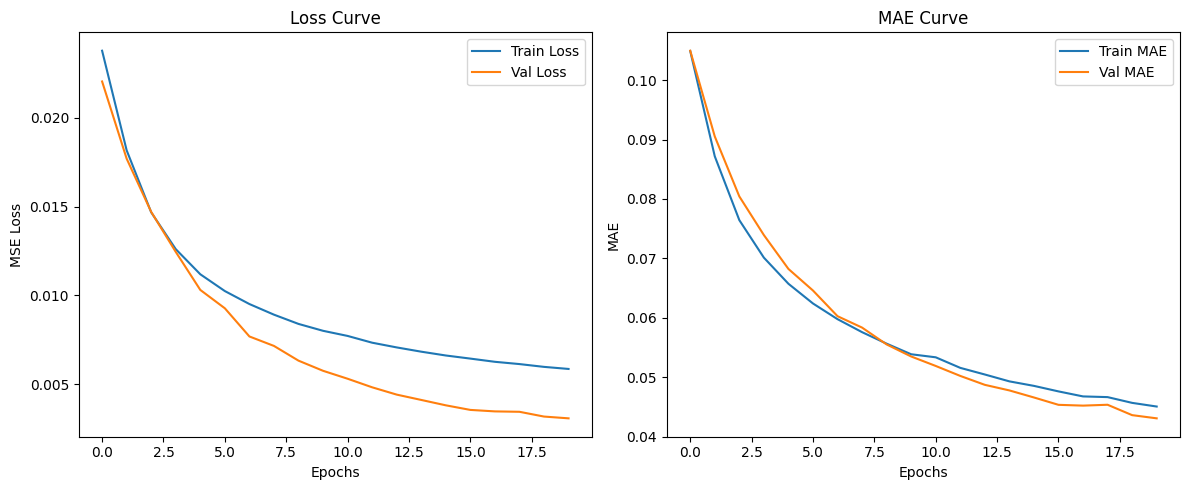

In [35]:
# Cell 14: Plot training and validation loss & MAE
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Loss Curve')
plt.legend()

# MAE curve
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Curve')
plt.legend()

plt.tight_layout()
plt.show()
